In [ ]:
import jax.numpy as np
from jax import random, vmap, jit
from jax.lax import scan, cond
from functools import partial
from jax.experimental import host_callback
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2}) 

In [ ]:
# From https://www.jeremiecoullon.com/2021/01/29/jax_progress_bar/
def progress_bar_scan(num_samples, message=None):
    "Progress bar for a JAX scan"
    if message is None:
            message = f"Running for {num_samples:,} iterations"
    tqdm_bars = {}
    
    if num_samples > 20:
        print_rate = int(num_samples / 20)
    else:
        print_rate = 1
    remainder = num_samples % print_rate
        
    def _define_tqdm(arg, transform):
        tqdm_bars[0] = tqdm(range(num_samples))
        tqdm_bars[0].set_description(message, refresh=False)

    def _update_tqdm(arg, transform):
        tqdm_bars[0].update(arg)
    
    def _update_progress_bar(iter_num):
        "Updates tqdm progress bar of a JAX scan or loop"
        _ = cond(
            iter_num == 0,
            lambda _: host_callback.id_tap(_define_tqdm, None, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = cond(
            # update tqdm every multiple of `print_rate` except at the end
            (iter_num % print_rate == 0) & (iter_num != num_samples-remainder),
            lambda _: host_callback.id_tap(_update_tqdm, print_rate, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )
        
        _ = cond(
            # update tqdm by `remainder`
            iter_num == num_samples-remainder,
            lambda _: host_callback.id_tap(_update_tqdm, remainder, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )
    
    def _close_tqdm(arg, transform):
        tqdm_bars[0].close()
    
    def close_tqdm(result, iter_num):
        return cond(
            iter_num == num_samples-1,
            lambda _: host_callback.id_tap(_close_tqdm, None, result=result),
            lambda _: result,
            operand=None,
        )
        

    def _progress_bar_scan(func):
        """Decorator that adds a progress bar to `body_fun` used in `lax.scan`.
        Note that `body_fun` must either be looping over `np.arange(num_samples)`,
        or be looping over a tuple who's first element is `np.arange(num_samples)`
        This means that `iter_num` is the current iteration number
        """

        def wrapper_progress_bar(carry, x):
            if type(x) is tuple:
                iter_num, *_ = x
            else:
                iter_num = x   
            _update_progress_bar(iter_num)
            result = func(carry, x)
            return close_tqdm(result, iter_num)

        return wrapper_progress_bar

    return _progress_bar_scan

In [ ]:
def metropolis(log_prob, sigma):
    def init(rng_key, bounds):
        lb, ub = bounds
        dim = lb.shape[0]
        x0 = random.uniform(rng_key, (dim,), minval=lb, maxval=ub)
        return x0
    @partial(jit, static_argnums=(0,))
    def sample(num_samples, rng_key, init_state):
        @progress_bar_scan(num_samples)
        def kernel(carry, i):
            key, state, logp = carry
            key, subkey = random.split(key)
            x = state + sigma * random.normal(subkey, state.shape)
            logp_prop = log_prob(x)
            u = random.uniform(key)
            cond = (u < np.exp(logp_prop - logp))
            state = np.where(cond, x, state)
            logp = np.where(cond, logp_prop, logp)
            return (key, state, logp), state
        logp = log_prob(init_state)
        _, samples = scan(kernel, (rng_key, init_state, logp), np.arange(num_samples))
        return samples
    return init, sample

In [ ]:
def circle():
    dim = 2
    lb = np.array([-2.0,-1.0])
    ub = np.array([4.0,5.0])
    def dist(x):
        u  = (x[0]-1)**2 + (x[1]-2)**2 - 3**2
        return np.exp(-u)
    return dist, dim, (lb, ub)

def rosenbrock(a=1.0, b=100.0):
    dim = 2
    lb = np.array([-3.0,-3.0])
    ub = np.array([3.0,10.0])
    def dist(x):
        u = ((a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2) / 20
        return np.exp(-u)
    return dist, dim, (lb, ub)

def double_well(a = 1.0, b = 5.0, c = 0.1, d = 0.4):
  dim = 2
  lb = np.array([-5.0,-5.0])
  ub = np.array([5.0,5.0])
  def dist(x):
      u = 1./4.*a*x[0]**4 - 1./2.*b*x[0]**2 + c*x[0] + 1./2.*d*x[1]**2
      return np.exp(-u)
  return dist, dim, (lb, ub)

In [ ]:
dist, dim, (lb, ub) = double_well()

log_prob = lambda x: np.log(dist(x))

nn = 128
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
grid = np.meshgrid(xx, yy)
X = np.array(grid).T.reshape(-1,dim)
P = vmap(dist)(X)

In [ ]:
step_size = 1.0
init_fn, sample_fn = metropolis(log_prob, step_size)

burn_in = 1000
num_steps = 20000
key = random.PRNGKey(0)
init_state = init_fn(key, (lb, ub))
samples = sample_fn(num_steps, key, init_state)[burn_in:,:]

  0%|          | 0/20000 [00:00<?, ?it/s]

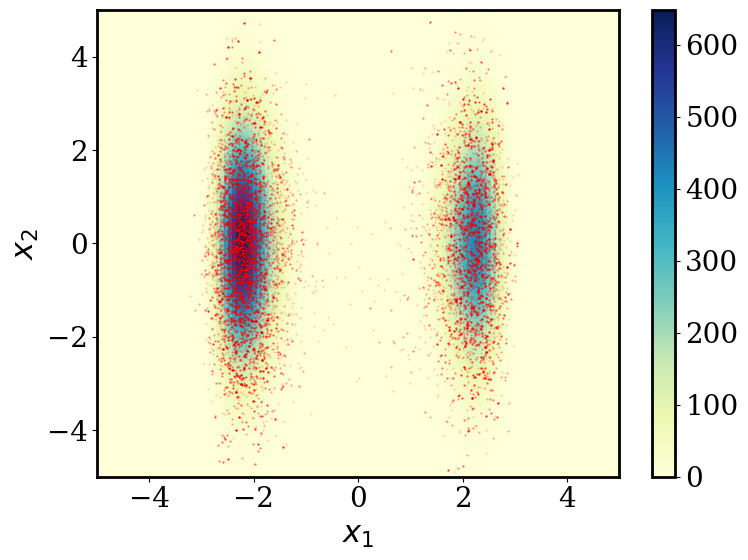

In [ ]:
plt.figure(figsize=(8,6))
plt.pcolor(grid[0], grid[1], P.reshape(nn,nn).T, cmap='YlGnBu')
plt.plot(samples[:,0], samples[:,1], 'r.', ms=1, alpha=0.2)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()
plt.show()

### How about multiple parallel chains? No problem thanks to `vmap` (or even `pmap` for distributing across multiple GPUs)

In [ ]:
step_size = 1.0
init_fn, sample_fn = metropolis(log_prob, step_size)

burn_in = 1000
num_steps = 20000
num_chains = 4
key = random.PRNGKey(0)
keys = random.split(key, num_chains)
init_states = vmap(init_fn, in_axes=(0,None))(keys, (lb, ub))
samples = vmap(sample_fn, in_axes=(None,0,0))(num_steps, keys, init_states)[:,burn_in:,:]

  0%|          | 0/20000 [00:00<?, ?it/s]

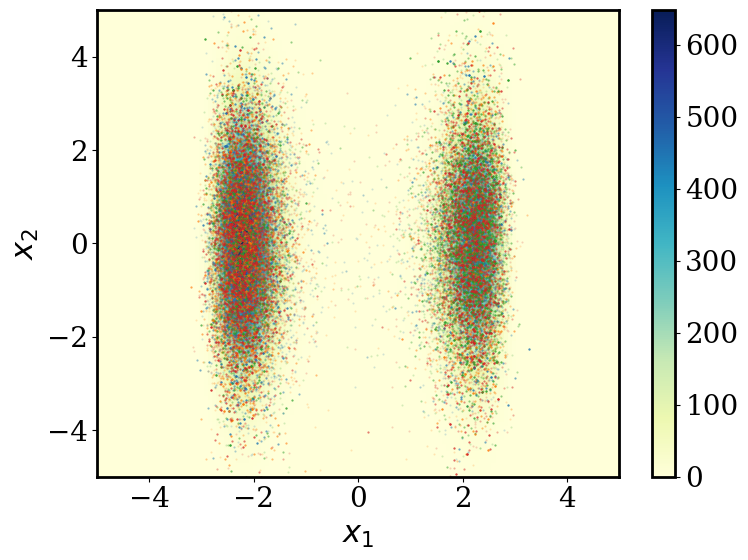

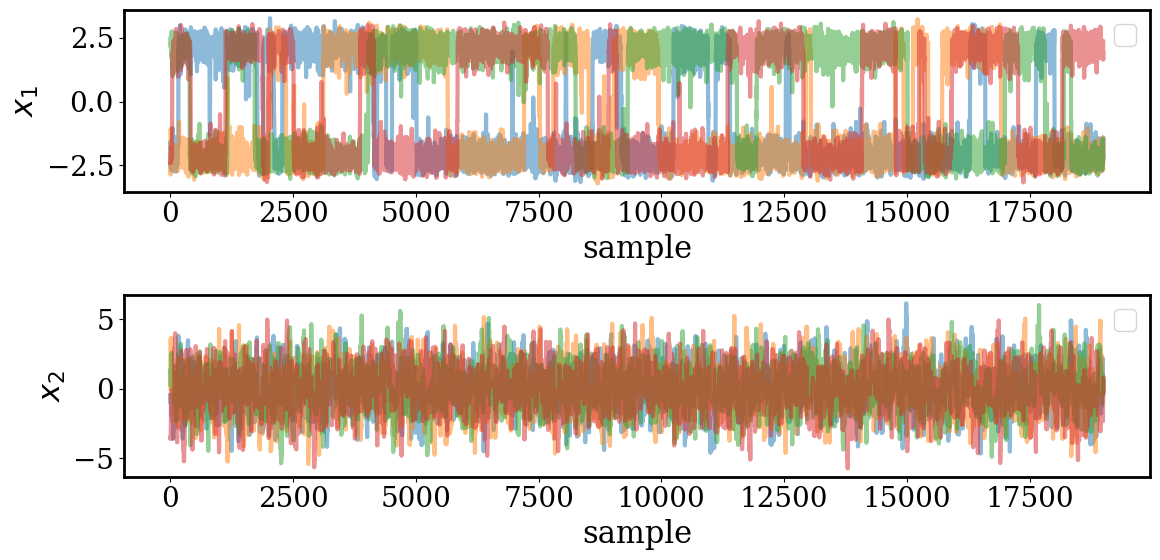

In [ ]:
plt.figure(figsize=(8,6))
plt.pcolor(grid[0], grid[1], P.reshape(nn,nn).T, cmap='YlGnBu')
for i in range(num_chains):
    plt.plot(samples[i,:,0], samples[i,:,1], '.', ms=1, alpha=0.2)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(np.arange(num_steps-burn_in), samples[:,:,0].T, alpha=0.5)
plt.legend()
plt.xlabel('sample')
plt.ylabel('$x_1$')

plt.subplot(2,1,2)
plt.plot(np.arange(num_steps-burn_in), samples[:,:,1].T, alpha=0.5)
plt.legend()
plt.xlabel('sample')
plt.ylabel('$x_2$')
plt.tight_layout()
plt.show()